In this project, we use the dataset available at https://www.kaggle.com/datasets/laotse/credit-risk-dataset.


Understanding the causal impact of loan interest rates on default risk is a critical challenge in the banking industry, as it directly influences pricing strategies, risk management, and financial inclusion efforts. Higher interest rates may increase the financial burden on borrowers, potentially leading to higher default rates, but this relationship can be confounded by factors such as income, credit history, and loan purpose. This project aims to perform a causal inference analysis to determine the effect of ``loan_int_rate`` on ``loan_status`` (0 for non-default, 1 for default) using a credit risk dataset. By isolating the causal effect, the analysis will provide actionable insights for lenders to optimize interest rate policies while minimizing default risk.

**Objectives**

- Quantify the causal effect of loan_int_rate on loan_status, assessing whether and to what extent higher interest rates lead to increased default probability.

- Identify and control for confounding variables to ensure an unbiased estimate of the causal effect.

- Validate the robustness of the causal estimate using sensitivity analysis.

**Dataset Overview**

The dataset contains borrower characteristics, loan details, and default history. The key variables are:

- ``person_age``: Borrower’s age (numerical).

- ``person_income``: Annual income in dollars (numerical).

- ``person_home_ownership``: Home ownership status (categorical).

- ``person_emp_length``: Employment length in years (numerical).

- ``loan_intent``: Purpose of the loan (categorical).

- ``loan_grade``: Credit grade of the loan (categorical).

- ``loan_amnt``: Loan amount in dollars (numerical).

- ``loan_int_rate``: Interest rate as a percentage (numerical), the **treatment** variable.

- ``loan_status``: Loan outcome (binary), the **outcome** variable.

- ``loan_percent_income``: Loan amount as a percentage of income (numerical).

- ``cb_person_default_on_file``: Historical default status (binary).

- ``cb_person_cred_hist_length``: Length of credit history in years (numerical).



In [107]:
from IPython.display import HTML
import warnings
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

warnings.filterwarnings("ignore")

In [108]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
import statsmodels.api as sm
from statsmodels.formula.api import logit, ols
from statsmodels.stats.diagnostic import het_breuschpagan

In [114]:
import seaborn as sns


### Removing rows with null values

In this dataset, there are 3943 rows with ``null`` values. As a preprocessing step, we remove these rows.

In [216]:
df = pd.read_csv('credit_risk_dataset.csv')
num_rows_with_nulls = df.isnull().any(axis=1).sum()
print(f"Number of rows with null values: {num_rows_with_nulls}")
df = df.dropna()
df

Number of rows with null values: 3943


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# 1. Outlier Detection 

In this section, we analyze only numerical variables. First, we visualize their distributions using boxplots, which reveal significant skewness and the presence of outliers—values that deviate from the rest of the data.

While traditional boxplot methods define outliers as points beyond the whiskers (typically 1.5 times the interquartile range), we adopt a more conservative approach. Specifically, we classify observations above the 90th percentile as outliers and remove them from the dataset. This threshold helps mitigate the impact of extreme values while preserving the integrity of the analysis.

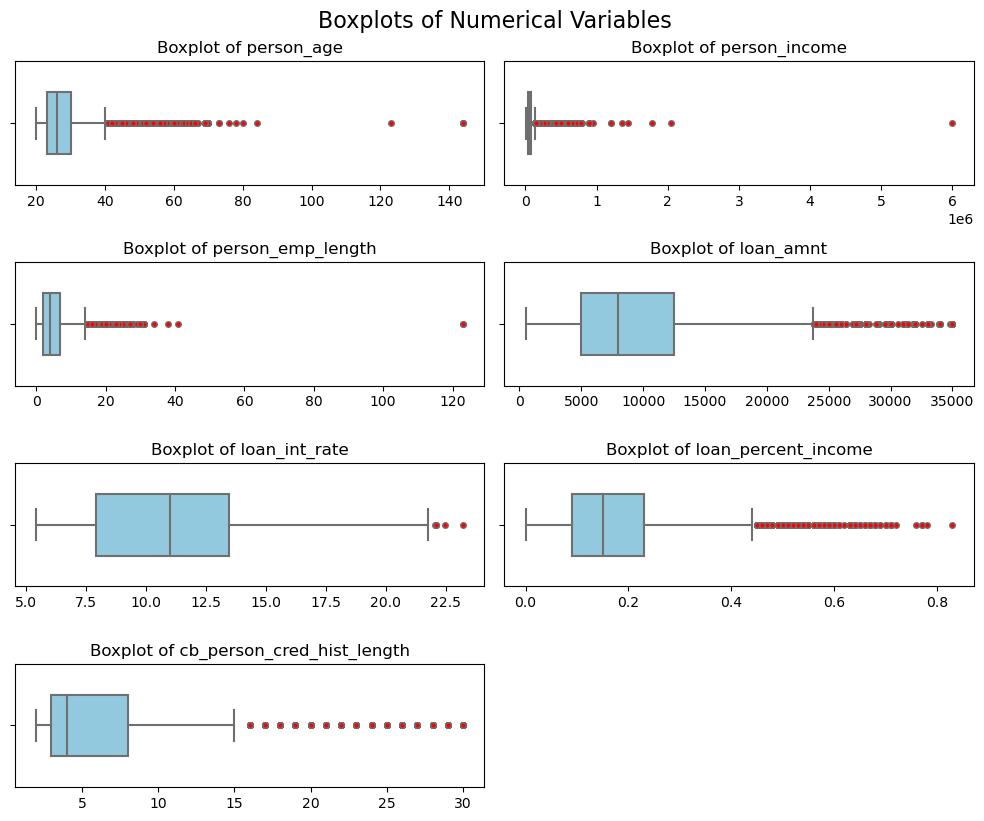

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_plot(df):

    numerical_vars = [
        'person_age','person_income', 'person_emp_length', 'loan_amnt', 
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    ]

    # Set up subplots
    n_cols = 2  # Number of columns in the grid
    n_rows = (len(numerical_vars) + n_cols - 1) // n_cols  # Calculate rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))


    axes = axes.flatten()

    # Generate boxplots for each numerical variable
    for i, var in enumerate(numerical_vars):
        sns.boxplot(
            x=df[var], 
            ax=axes[i], 
            color='skyblue', 
            width=0.5,
            flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'red'}
        )
        axes[i].set_title(f'Boxplot of {var}', fontsize=12)
        axes[i].set_xlabel('')

    # Remove empty subplots (if any)
    for j in range(len(numerical_vars), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.suptitle('Boxplots of Numerical Variables', y=1.02, fontsize=16)
    plt.show()
    
box_plot(df)

In [218]:
percentile = 0.90
columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income','cb_person_cred_hist_length']
for i in columns:
    print(str(int(percentile*100))+'-percentile of '+ str(i)+' : ',df[i].quantile(percentile))


90-percentile of person_age :  36.0
90-percentile of person_income :  112000.0
90-percentile of person_emp_length :  10.0
90-percentile of loan_amnt :  19464.999999999964
90-percentile of loan_percent_income :  0.32
90-percentile of cb_person_cred_hist_length :  11.0


In [219]:
df= df[df['person_income']<=df['person_income'].quantile(percentile)]
df= df[df['person_age']<=df['person_age'].quantile(percentile)]
df= df[df['person_emp_length']<=df['person_emp_length'].quantile(percentile)]
df= df[df['loan_amnt']<=df['loan_amnt'].quantile(percentile)]
df= df[df['loan_percent_income']<=df['loan_percent_income'].quantile(percentile)]
df= df[df['cb_person_cred_hist_length']<=df['cb_person_cred_hist_length'].quantile(percentile)]

The following boxplots show substantially lighter tails, confirming that our method successfully mitigated skewness without excessive data loss. This refinement enhances the reliability of subsequent analyses by reducing distortion from extreme values.

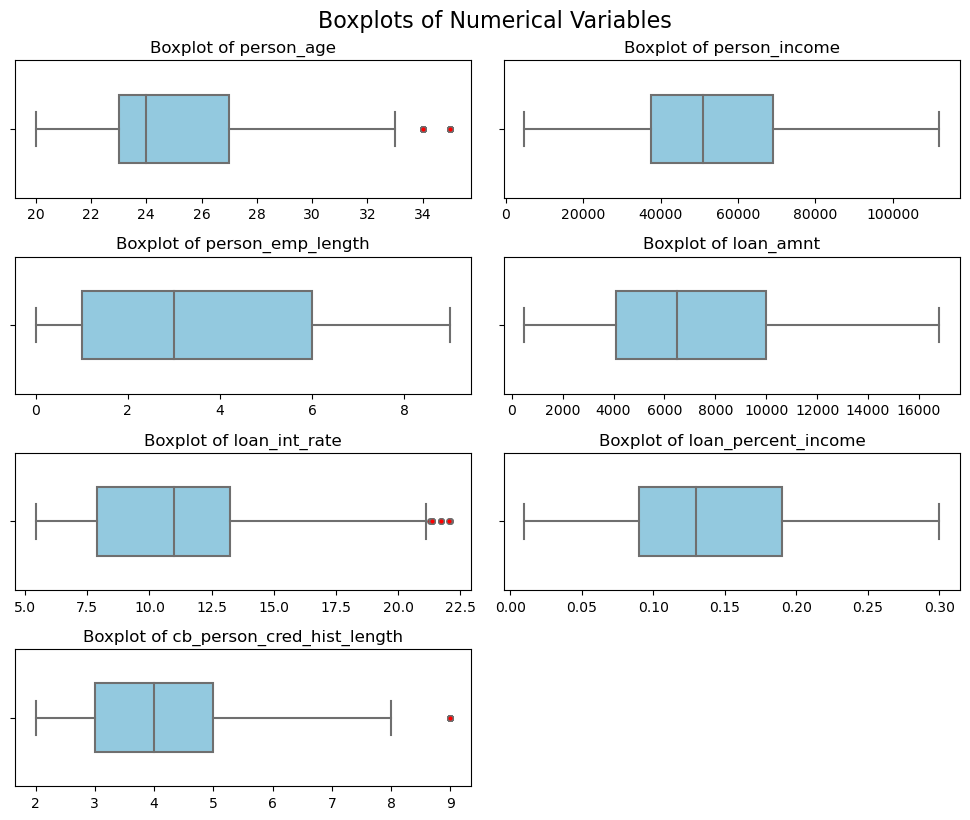

In [220]:
box_plot(df)

# 1. Explanatory Data Analyses



### Distribution of ``loan_status`` (Outcome)

First, we want to check the distribution of the outcome. Based on the following graph, the data is a bit imbalanced, but not too extreme.

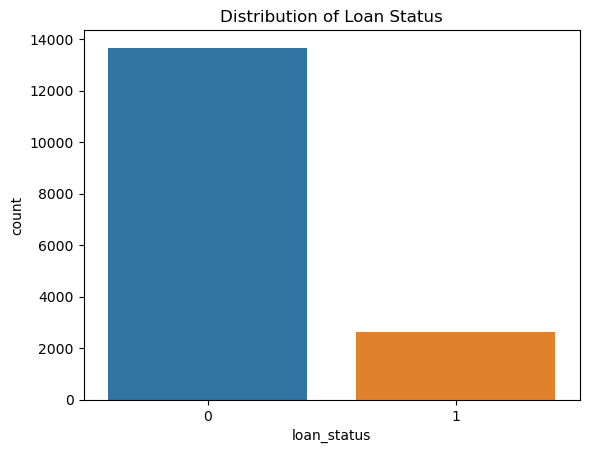

In [221]:
# Distribution of loan_status (target variable)
sns.countplot(x='loan_status', data=df)
plt.title("Distribution of Loan Status")
plt.show()



In the following figure, the scatterplot matrix of varibales for customers with and without default.

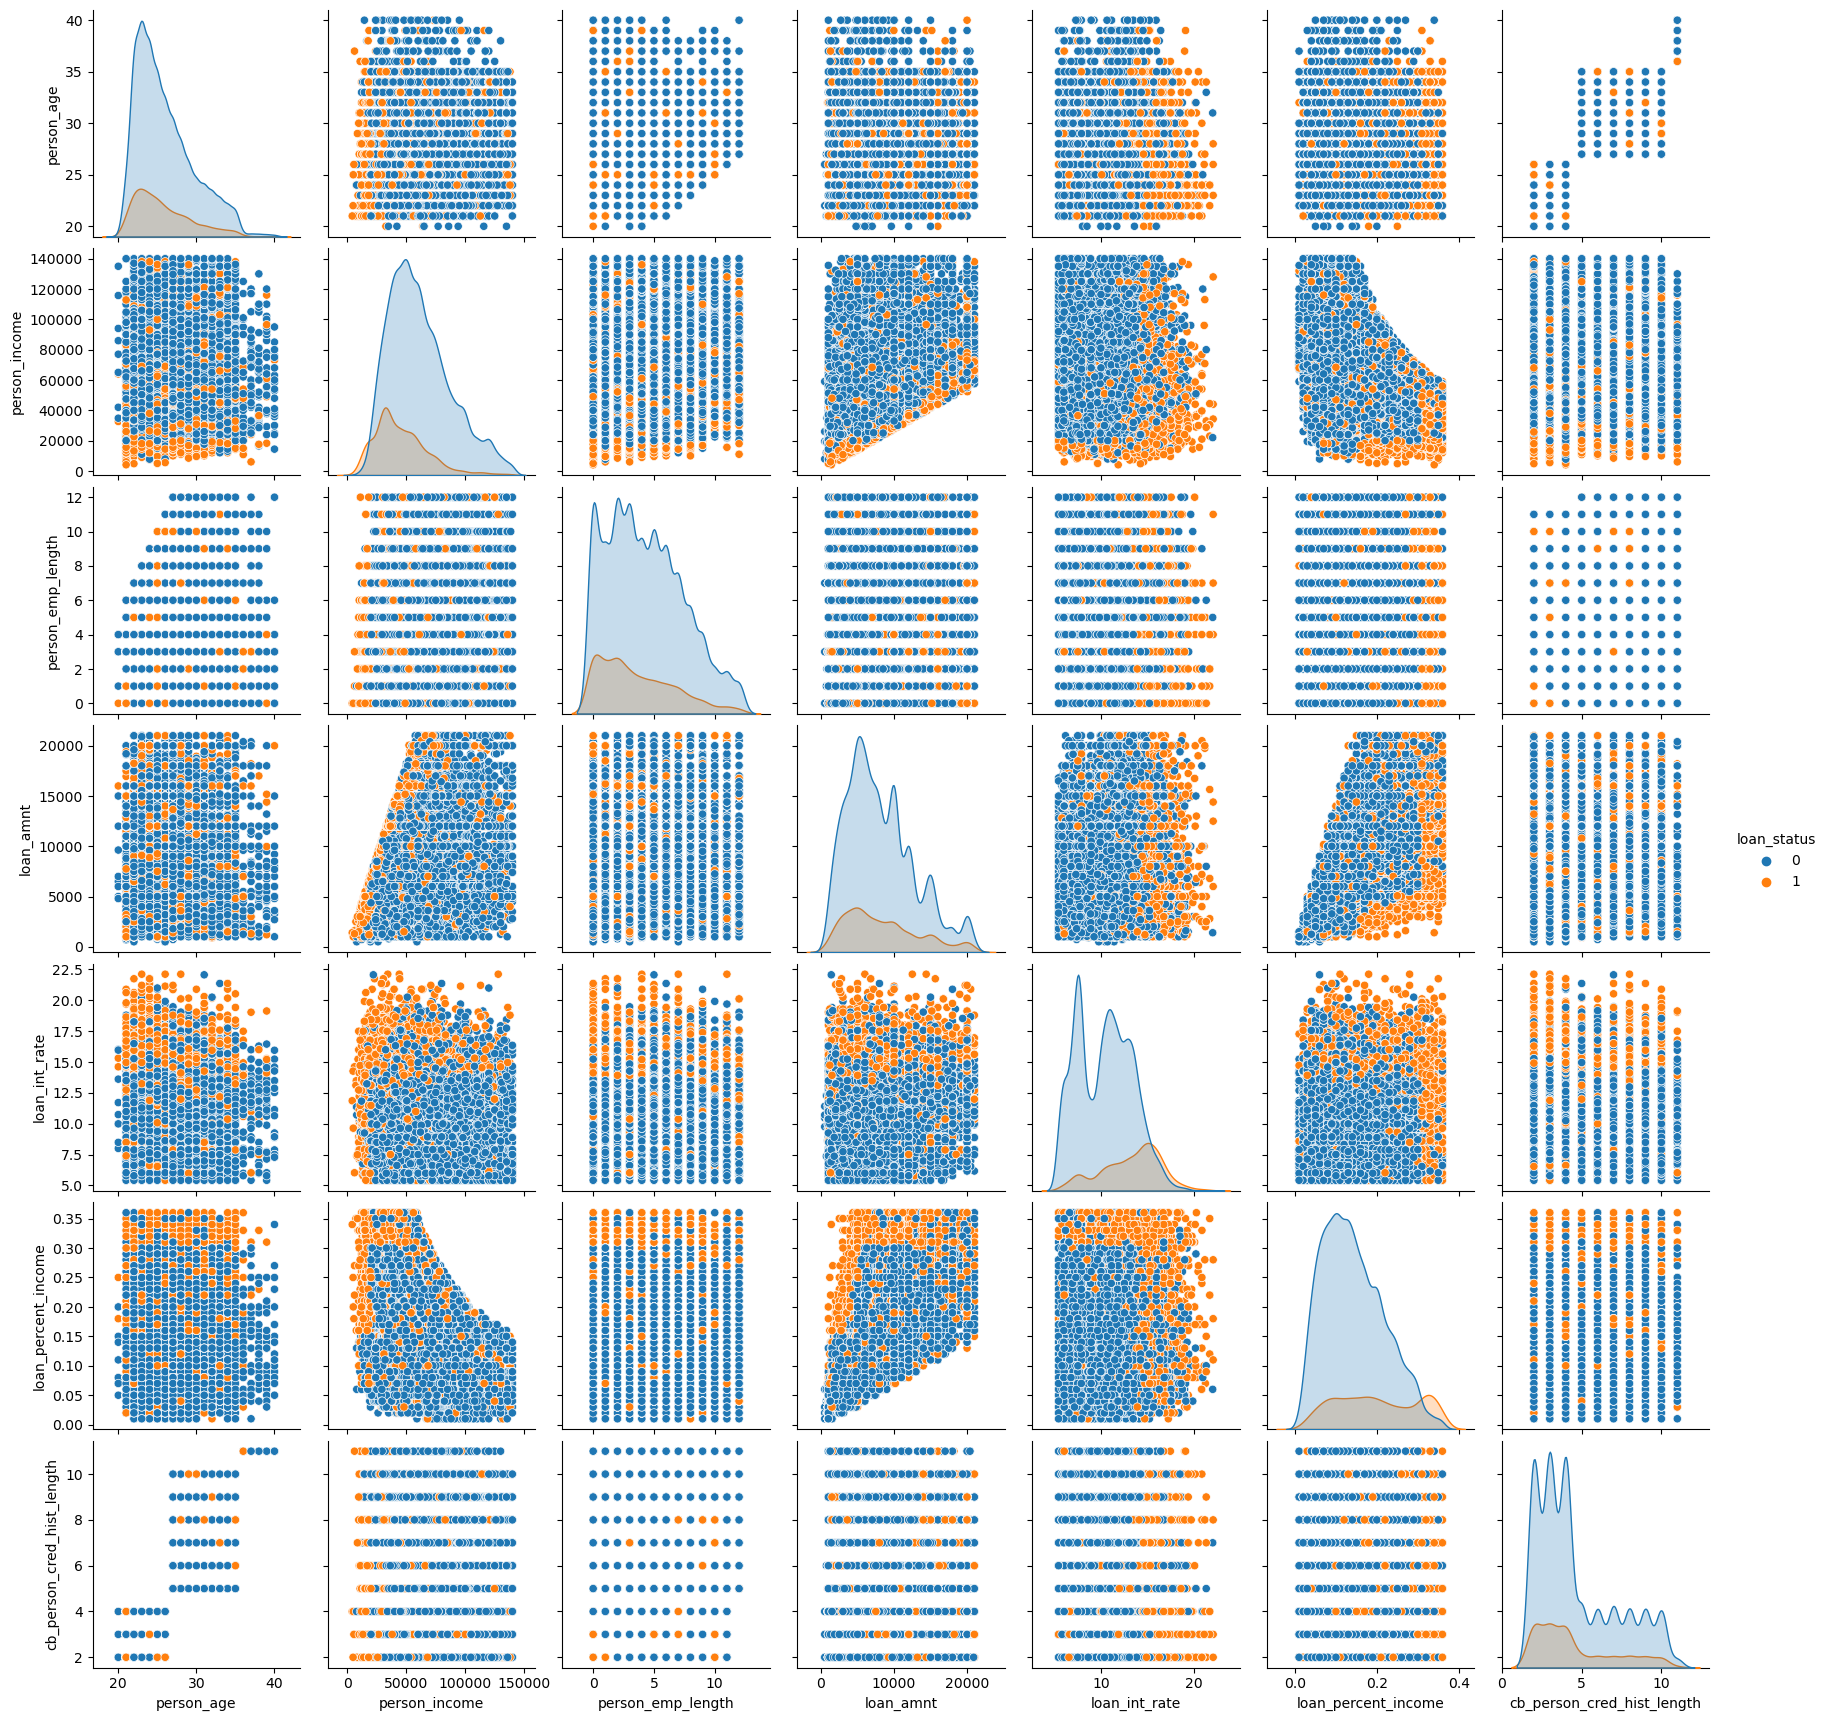

In [14]:
sns.pairplot(df,hue="loan_status")

### Distribution of ``loan_int_rate`` (Treatment)

Most loans have rates between 5% and 10%, with the mod around 7.5%, meaning this is the most common rate. Rates above 15% are less frequent. This suggests that borrowers typically get lower interest rates, while very high rates are rare.


Summary statistics for loan_int_rate:
count    12251.000000
mean        10.838656
std          3.163068
min          5.420000
25%          7.880000
50%         10.990000
75%         13.220000
max         22.110000
Name: loan_int_rate, dtype: float64


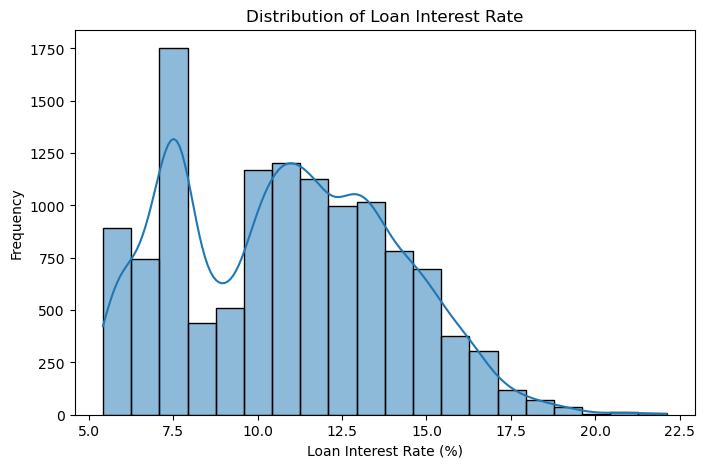

In [38]:
# Summary statistics for loan_int_rate
print("Summary statistics for loan_int_rate:")
print(df['loan_int_rate'].describe())

# Visualize the distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['loan_int_rate'], bins=20, kde=True)
plt.title("Distribution of Loan Interest Rate")
plt.xlabel("Loan Interest Rate (%)")
plt.ylabel("Frequency")
plt.show()

### ``loan_status`` vs ``Loan_int_Rate``

In this project, we are going to investigate if there there is any causal relationship between interest rate and the status of the loan.

The boxplot compares loan interest rates between borrowers who repaid (0) and those who defaulted (1). On average, borrowers who defaulted had higher interest rates (around 13%) compared to those who repaid (around 11%). The boxes show that most repaid loans had rates between \~9-12%, while defaulted loans were more spread out (~10-16%). This suggests that higher interest rates may be linked to a greater risk of default.

It should be also mention that there might be other factors which have effects on both ``loan_int_rate`` and ``loan_status``. In this project, we are going to estimate the true effect of interest rates on the probability of default.



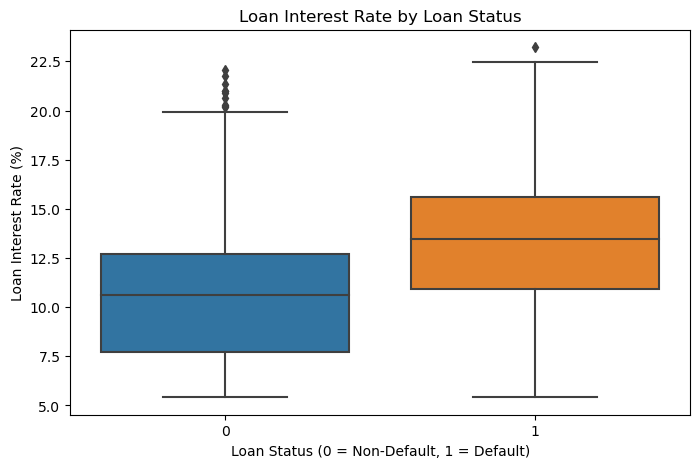

Mean loan_int_rate by loan_status:
loan_status
0    10.463636
1    13.123975
Name: loan_int_rate, dtype: float64


In [18]:
# Boxplot of loan_int_rate by loan_status
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_status', y='loan_int_rate', data=df)
plt.title("Loan Interest Rate by Loan Status")
plt.xlabel("Loan Status (0 = Non-Default, 1 = Default)")
plt.ylabel("Loan Interest Rate (%)")
plt.show()

# Mean loan_int_rate for each loan_status
print("Mean loan_int_rate by loan_status:")
print(df.groupby('loan_status')['loan_int_rate'].mean())

### Distribution of ``loan_grade``

In our dataset, grade **A** corresponds to the loans with the lowest risks and loans with grade **G** are those with the highest risks. Based on the bar chart, majority of observations are related to the low risk loans (A, B, and C). Therefore, later when we want to add interaction term in the ``logistic regression`` model, we combine high-risk loans (**D-G**).

<Axes: xlabel='loan_grade', ylabel='count'>

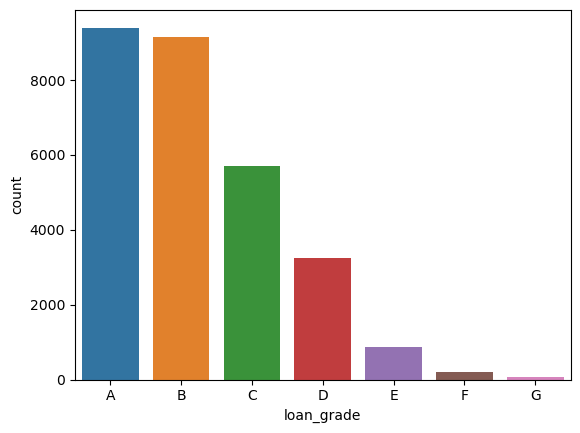

In [23]:
sns.countplot(x='loan_grade', data=df, order=sorted(df['loan_grade'].unique()))

### Frequency of ``loan_grade`` at different levels

Based on the following figure, when the loan is not risky (``loan_grade`` is either of **A**, **B**, or **C**), more customers have paid the loan and the chance of the default is lower. On the other hand, when the loan is risky (``loan_grade`` is either of **D**, **E**, **F**, or **GG**), the fraction of customers who could not pay the loan in higher.

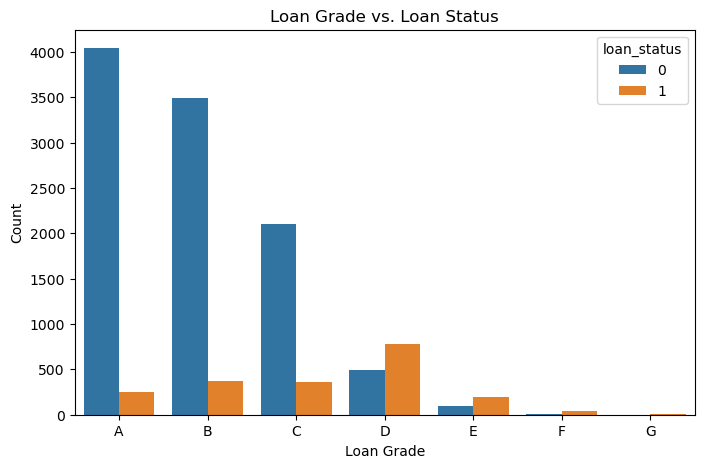

In [39]:
# Loan grade vs. loan_status
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_grade', hue='loan_status', data=df, order=sorted(df['loan_grade'].unique()))
plt.title("Loan Grade vs. Loan Status")
plt.xlabel("Loan Grade")
plt.ylabel("Count")
plt.show()

### The relationship between ``person_income`` and ``loan_status``

Based on the following figure, people who paid the loan have a higher income on average compared to those defaulted. 

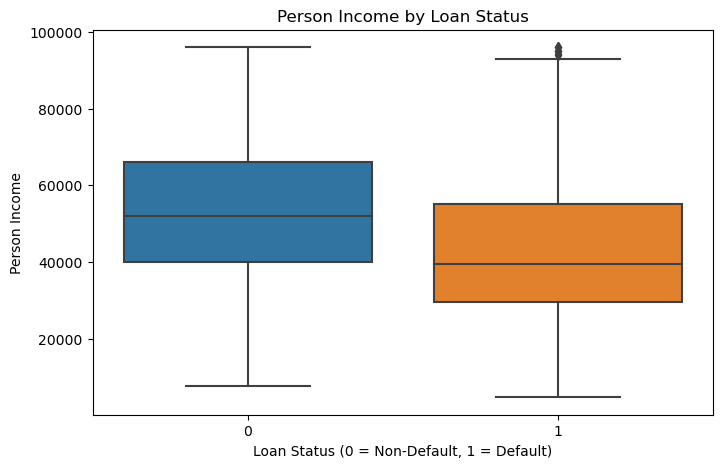

In [41]:
# Person income vs. loan_status
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_status', y='person_income', data=df)
plt.title("Person Income by Loan Status")
plt.xlabel("Loan Status (0 = Non-Default, 1 = Default)")
plt.ylabel("Person Income")
plt.show()

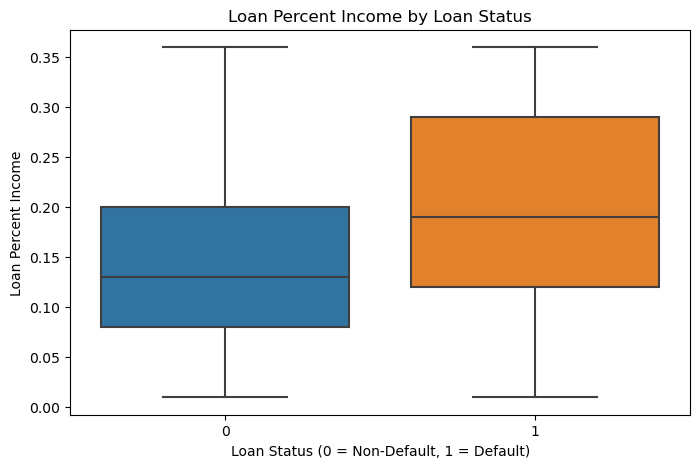

In [55]:
# Loan percent income vs. loan_status
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_status', y='loan_percent_income', data=df)
plt.title("Loan Percent Income by Loan Status")
plt.xlabel("Loan Status (0 = Non-Default, 1 = Default)")
plt.ylabel("Loan Percent Income")
plt.show()

### The relationship between ``loan_int_rate`` and ``loan_grade``

In the previous figures, we showed that the default chance is higher for riskier loans. 
Based on the following figure, we observe that riskiers loans have higher interest rate and because higher interest rate can increase the default rate, so, it can explain an indirect impact of ``loan_grade`` on the default rate.

Text(0, 0.5, 'Loan Interest Rate (%)')

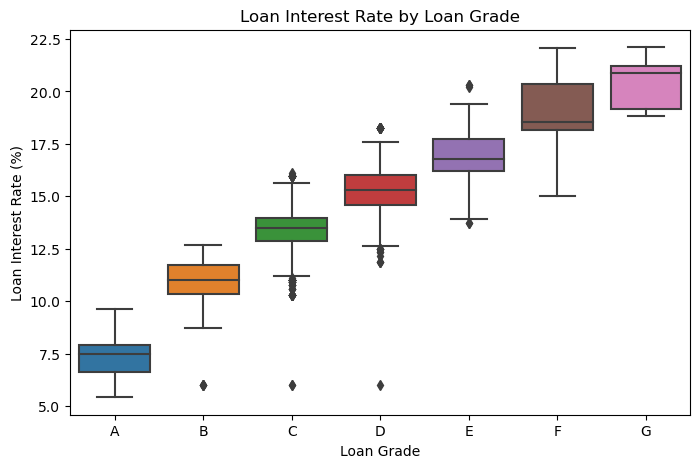

In [40]:
# Loan grade vs. loan_int_rate
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=df, order=sorted(df['loan_grade'].unique()))
plt.title("Loan Interest Rate by Loan Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Loan Interest Rate (%)")

### Frequency of ``person_home_ownership`` at different levels

Based on the following figure, the frequency of levels of ``person_home_ownership`` are not uniform and there are only observations with level **OTHER**. Therefore, we expect that adding the interaction of ``person_home_ownership`` and ``loan_int_rate`` will not be a good choice. 

<Axes: xlabel='person_home_ownership', ylabel='count'>

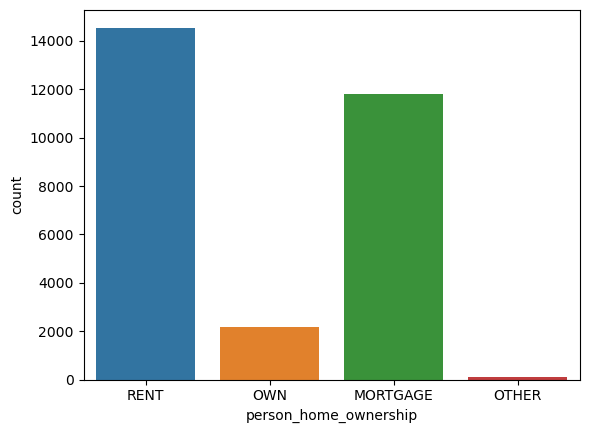

In [563]:
sns.countplot(x='person_home_ownership', data=df)

<Axes: xlabel='person_home_ownership', ylabel='Count'>

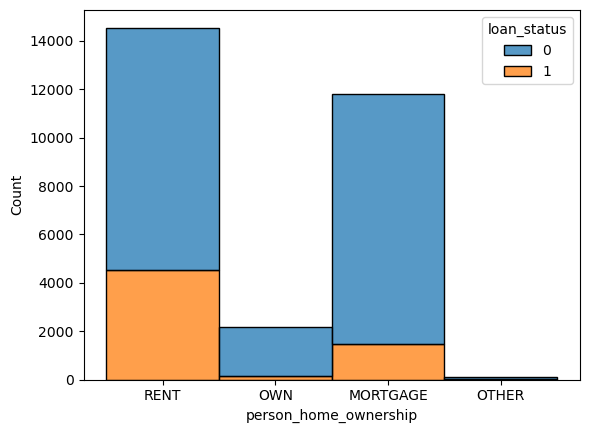

In [574]:
sns.histplot(data=df, x="person_home_ownership", hue="loan_status", multiple="stack", discrete=True)

### Correlation matrix of numerical features

In the following, we calculate the correlation matrix of all numerical variables. Since the correlation between ``person_age`` and ``cb_person_cred_hist_length`` is high, it means that if we include both of them in our model, multicollinearity is liekly to happen. Therefore, we need to remove one of these variables. 

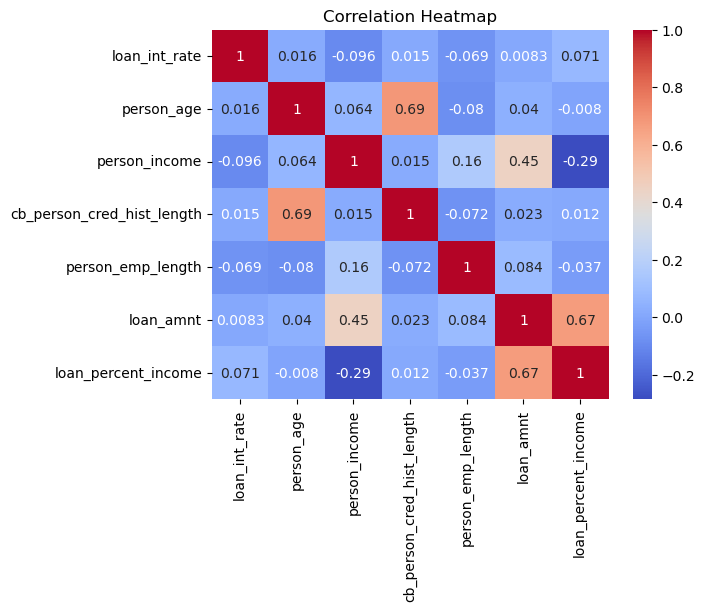

,loan_int_rate,person_age,person_income,cb_person_cred_hist_length,person_emp_length,loan_amnt,loan_percent_income
loan_int_rate,1.000000,0.016187,-0.096006,0.015163,-0.068589,0.008294,0.070652
person_age,0.016187,1.000000,0.064316,0.688117,-0.080441,0.039757,-0.008023
person_income,-0.096006,0.064316,1.000000,0.015496,0.164506,0.446322,-0.286114
cb_person_cred_hist_length,0.015163,0.688117,0.015496,1.000000,-0.072334,0.023458,0.011807
person_emp_length,-0.068589,-0.080441,0.164506,-0.072334,1.000000,0.083624,-0.037142
loan_amnt,0.008294,0.039757,0.446322,0.023458,0.083624,1.000000,0.670771
loan_percent_income,0.070652,-0.008023,-0.286114,0.011807,-0.037142,0.670771,1.000000


In [42]:
# Correlation heatmap
corr = df[['loan_int_rate', 'person_age', 'person_income', 'cb_person_cred_hist_length', 'person_emp_length', 'loan_amnt', 'loan_percent_income']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

corr

# 2. Variables in the Model

In this model, we want to determine the impact of **loan interest rate** (``loan_int_rate``) on the **load default** (``loan_status``). So, the **treatment variable** is ``loan_int_rate``, and the **outcome** variable is ``loan_status``.


In any causal model, in addition to the **treatment** and **outcome** variables, we have some other variables including **Confounders**, **Instrumental Variables (IVs)**, **Mediators**, and **Colliders**. In the following, we explain how these variables affect the treatment and/or the outcome.

1. **Confounders**: Variables that affect both the **treatment** and **outcome**, creating spurious associations.


2. **Instrumental Variables (IVs)**: Variables that affect the **treatment** but have no direct effect on the **outcome** (except through the treatment).

3. **Mediators**: Variables on the causal path between **treatment** and **outcome**.

4. **Colliders**: Variables influenced by both the **treatment** and **outcome** (conditioning on them introduces bias).

<br>

### Causal Roles of Variables

| **Variable**                  | **Role**       | **Rationale**                                                                 |
|-------------------------------|----------------|-------------------------------------------------------------------------------|
| **Confounders**               |                |                                                                               |
| `person_age`                  | Confounder     | Older borrowers receive better rates (longer credit history) and lower default risk. |
| `person_income`               | Confounder     | Higher income → lower interest rates and lower default risk.                  |
| `person_home_ownership`       | Confounder     | Homeownership (e.g., MORTGAGE) → better loan terms and lower default risk.    |
| `loan_intent`                 | Confounder     | Loan purpose (e.g., MEDICAL) affects both interest rates and default behavior. |
| `loan_grade`                  | Confounder     | Risk grade (A/B/C/D) directly affects interest rates and default risk.        |
| `person_emp_length`           | Confounder     | Longer employment → lower rates and lower default risk.                       |
| `cb_person_default_on_file`   | Confounder     | Prior defaults → higher rates and higher future default risk.                 |
| `cb_person_cred_hist_length`  | Confounder     | Longer credit history → better terms (lower rates) and lower default risk.    |
| `loan_amnt`                   | Confounder       | Interest rate may affect loan amount, which influences default risk.          |
| **Mediators**                 |                |                                                                               |
| `loan_percent_income`         | Mediator       | Higher interest rates → higher monthly payments (↑% of income) → higher default risk. |
| **Treatment**                 |                |                                                                               |
| `loan_int_rate`               | Treatment      | The variable whose causal effect on `loan_status` is being estimated.         |
| **Outcome**                   |                |                                                                               |
| `loan_status`                 | Outcome        | Binary indicator of loan default (0 = no default, 1 = default).               |

<br> <br> 

Based on the current dataset, there is no variable that satisfy the IV exclusion restriction (affect treatment but not outcome directly). Therefore, there is **no Instrumental Variable** in the dataset.

## 2.1. EDA for Confounders

**Confounders** variables that affect both the treatment and outcome, creating spurious associations. In the previous parts, we investigated the impact of variables on ``loan_status``. Now, we are going to see if there is any relationship between confounders and the treatment variable.

### Investigating the relationship between ``person_income`` and ``loan_int_rate``

The correlation is so small, indicating **no linear relationship** (or weak relationship) between ``person_income`` (income) and ``loan_int_rate`` (interest rate).

Income explains **almost none** of the variability in interest rates. The slight negative value is negligible and likely due to random noise. It should be noted that P-value is almost zero meaning the significance of the correlation coefficient. However, it can be because of large sample size. 

Although, statistically, ``person_income`` is not correlated with ``loan_interest_rate`` and it is expected to be a insignificant variable, we need to include this variable in our analysis because it reduces the bias.

In [43]:
from scipy.stats import pearsonr
import pandas as pd

# Pearson correlation and p-value
corr, p_value = pearsonr(df['person_income'], df['loan_int_rate'])

print(f"Pearson Correlation Coefficient: {corr:.3f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: -0.096
P-value: 0.0000


Based on the following figure, when ``person_income`` increases, the interest rate slightly decreases on average. 

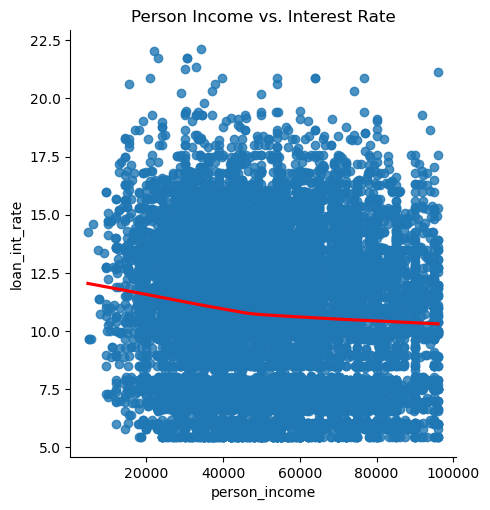

In [45]:
# Scatter plot: Income vs. Interest Rate
sns.lmplot(x='person_income', y='loan_int_rate', data=df, line_kws={'color': 'red'}, lowess=True)
plt.title('Person Income vs. Interest Rate')
plt.show()

## Investigating the relationship between ``loan_grade`` and ``load_int_rate``.


Since the correlation is close to 1 and p-value is so small, it means that as the loan grade worsens (e.g., from "A" to "D"), the interest rate increases almost perfectly monotonically.

Riskier loan grades (e.g., "D") are strongly associated with higher interest rates.

This aligns with lending practices where riskier borrowers are charged higher rates.

It should be noted that since ``loan_grade`` is an ordinal variable and ``loan_int_rate`` is a numerical variable, we use **spearmanr** rank correlation method.

In [46]:
from scipy.stats import spearmanr

# Example: Correlation between `loan_grade` (ordinal) and `loan_int_rate` (numeric)
corr, p_value = spearmanr(df['loan_grade'], df['loan_int_rate'])
print(f"Spearman’s Correlation: {corr:.3f}, p-value: {p_value:.4f}")

Spearman’s Correlation: 0.944, p-value: 0.0000


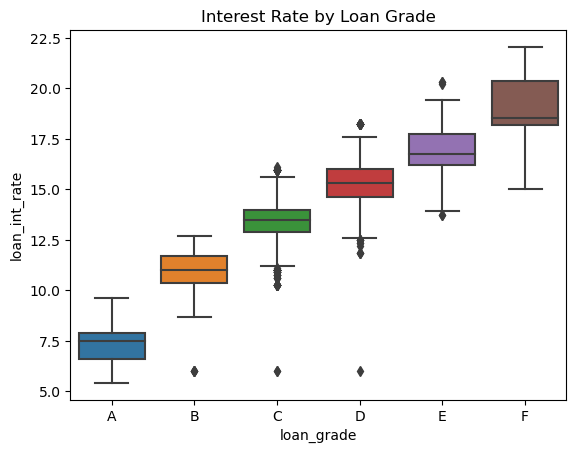

In [47]:
# Boxplot: Interest rate vs. loan grade
sns.boxplot(x='loan_grade', y='loan_int_rate', data=df,order=['A','B','C','D','E','F'])
plt.title("Interest Rate by Loan Grade")
plt.show()

### Investigating the relationship between ``cb_person_default_on_file`` and ``loan_int_rate``.

This indicates a **positive relationship** between having a historical default (``cb_person_default_on_file = Y``) and the loan interest rate (``loan_int_rate``).

Magnitude: A value of **0.5** (on a scale of -1 to 1) suggests that borrowers with a prior default (``Y``) are consistently associated with **much higher interest rates** compared to those without (``N``).

Since ``cb_person_default_on_file`` is a binary variable, we use **pointbiserialr** correlation.

In [48]:
from scipy.stats import pointbiserialr

# Convert Y/N to 1/0
default_flag = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

# Calculate correlation
corr, p_value = pointbiserialr(default_flag, df['loan_int_rate'])
print(f"Point-Biserial Correlation: {corr:.3f}, p-value: {p_value:.4f}")

Point-Biserial Correlation: 0.505, p-value: 0.0000


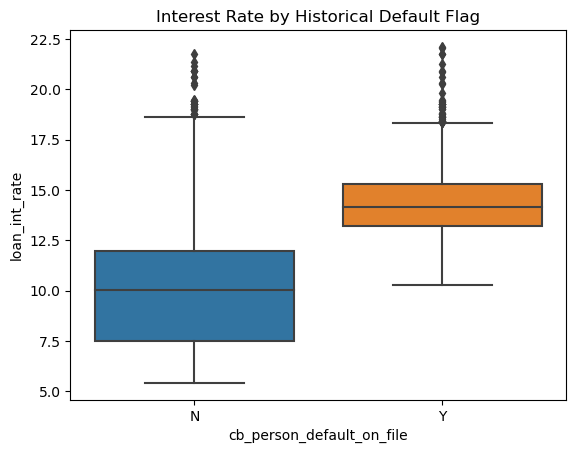

In [49]:
# Boxplot: Historical Default Flag vs. Interest Rate
sns.boxplot(x='cb_person_default_on_file', y='loan_int_rate', data=df)
plt.title('Interest Rate by Historical Default Flag')
plt.show()

### Investigating the relationship between ``person_home_ownership`` and ``loan_int_rate``.


The large Kruskal-Wallis Statistic indicates **significant differences** in the distribution of ``loan_int_rate`` across the categories of ``person_home_ownership`` (e.g., **RENT, OWN, MORTGAGE, OTHER**).

The p-value is effectively zero, meaning the differences in interest rates across home ownership categories are **statistically significant** at any conventional level (α = 0.05, 0.01, etc.).

In [50]:
from scipy.stats import kruskal

# Example: Compare `loan_int_rate` across categories of `person_home_ownership`
groups = [df[df['person_home_ownership'] == category]['loan_int_rate'] for category in df['person_home_ownership'].unique()]
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis Statistic: {stat:.3f}, p-value: {p_value:.4f}")

Kruskal-Wallis Statistic: 328.152, p-value: 0.0000


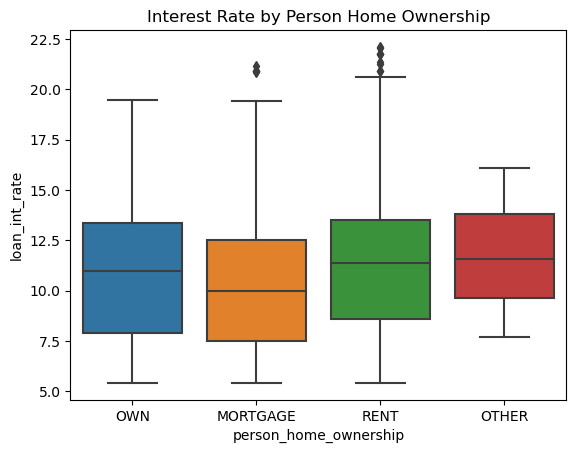

In [51]:
# Boxplot: Interest rate vs. person home ownership
sns.boxplot(x='person_home_ownership', y='loan_int_rate', data=df)
plt.title("Interest Rate by Person Home Ownership")
plt.show()

### Investigating the relationship between ``loan_intent`` and ``load_int_rate``

Based on the following results, it shows that ``load_int_rate`` is statistically different in at least one of the levels of ``loan_intent``.

In [52]:
from scipy.stats import kruskal

# Example: Compare `loan_int_rate` across categories of `loan_intent`
groups = [df[df['loan_intent'] == category]['loan_int_rate'] for category in df['loan_intent'].unique()]
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis Statistic: {stat:.3f}, p-value: {p_value:.4f}")

Kruskal-Wallis Statistic: 12.977, p-value: 0.0236




The p-value of **0.0236** (less than the common significance threshold of 0.05) indicates **statistically significant differences** in loan_int_rate (interest rates) across the categories of loan_intent (loan purposes).

**Reject the null hypothesis**: The distributions of interest rates are **not the same** across all loan purposes.

It should be noted that small P-value can be because of large samlpe size since visually, there is no significant difference between the distribution of interest rate in different levels of ``loan_intent``.

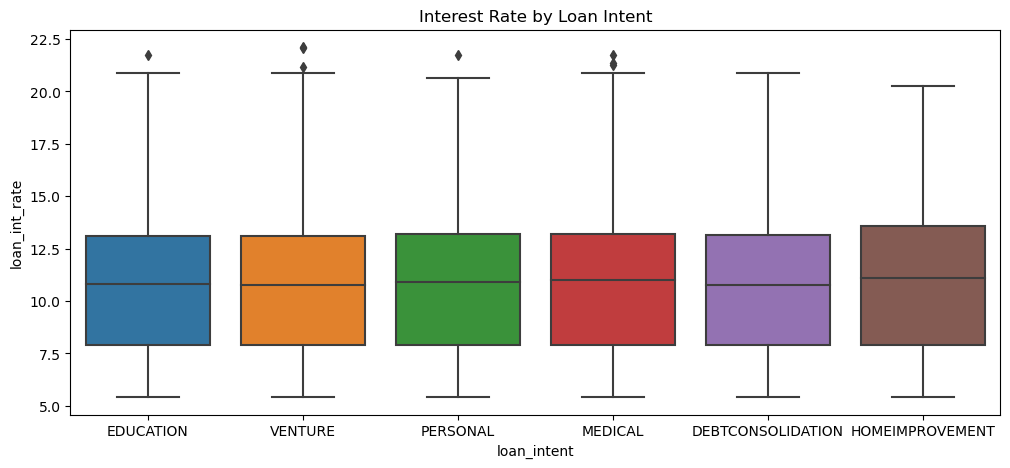

In [53]:
# Boxplot: Interest rate vs. loan intent
plt.figure(figsize=(12,5))
sns.boxplot(x='loan_intent', y='loan_int_rate', data=df)
plt.title("Interest Rate by Loan Intent")
plt.show()



### Investigating the relationship between ``loan_int_rate`` and ``person_emp_length``

The correlation is **very weak and negative**.

As ``person_emp_length`` (employment length) increases, ``loan_int_rate`` (interest rate) decreases slightly.

Employment length explains almost no meaningful variance in interest rates. Specifically:
$R^2 =(-0.069)^2 =0.4761\%$, meaning employment length accounts for only **0.4761%** of the variability in interest rates.

**Statistical Significance**: The small p-value indicates that this tiny relationship is unlikely due to random chance, but the practical impact is minimal.

In [54]:
from scipy.stats import pearsonr
import pandas as pd

# Drop rows with missing values in the relevant columns
df_clean = df[['person_emp_length', 'loan_int_rate']].dropna()

# Calculate Pearson correlation and p-value
corr, p_value = pearsonr(df_clean['person_emp_length'], df_clean['loan_int_rate'])

print(f"Pearson Correlation Coefficient: {corr:.3f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: -0.069
P-value: 0.0000


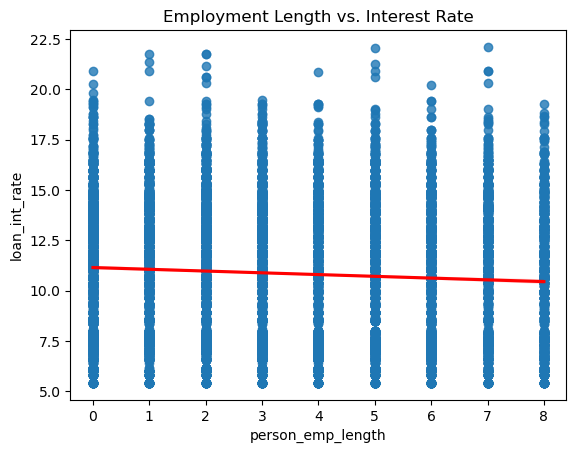

In [55]:
# Scatter plot: Employment Length vs. Interest Rate
sns.regplot(x='person_emp_length', y='loan_int_rate', data=df, line_kws={'color': 'red'})
plt.title('Employment Length vs. Interest Rate')
plt.show()

## Investigating the relationship between ``loan_amnt`` and ``loan_int_rate``.

Since the Pearson correlation coefficient is almost zero and P-value is large, we can conclude that there is no significant linear relationship between ``loan_amnt`` and ``loan_int_rate``.

Pearson Correlation Coefficient: 0.008
P-value: 0.3586


<Axes: xlabel='loan_amnt', ylabel='loan_int_rate'>

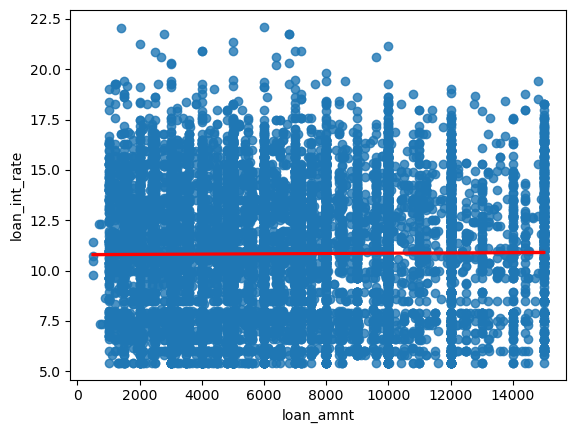

In [61]:
# Pearson correlation and p-value
corr, p_value = pearsonr(df['loan_amnt'], df['loan_int_rate'])

print(f"Pearson Correlation Coefficient: {corr:.3f}")
print(f"P-value: {p_value:.4f}")


sns.regplot(x='loan_amnt', y='loan_int_rate', data=df, line_kws={'color': 'red'})


# 3. Data Encoding and Standardizing

Since there are some categorical variables, we use one-hot encoding to convert those variables to 0/1 dummy variables. It should be noted that by using one-hot encoding, we can exactly determine the impact of each level on the treatment or the outcome.

In [222]:
# Encode categorical variables (e.g., Y/N to 1/0)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0}).astype(int)

# Convert categorical features to dummy variables
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = (df[col]==True)*1

df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
1,21,9600,5.0,1000,11.14,0,0.10,0,2,0,...,0,0,0,0,1,0,0,0,0,0
5,21,9900,2.0,2500,7.14,1,0.25,0,2,0,...,0,0,0,1,0,0,0,0,0,0
9,21,10000,6.0,1600,14.74,1,0.16,0,3,0,...,0,0,0,1,0,0,1,0,0,0
19,24,10800,8.0,1750,10.99,1,0.16,0,2,0,...,0,0,0,0,1,0,0,0,0,0
23,24,10980,0.0,1500,7.29,0,0.14,0,3,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112,28,31000,7.0,3600,14.11,1,0.12,1,8,0,...,0,1,0,0,0,0,1,0,0,0
29113,32,89000,0.0,12000,8.94,0,0.13,0,6,0,...,0,1,0,0,0,0,0,0,0,0
29115,29,61656,4.0,15000,6.91,0,0.24,0,9,0,...,0,0,1,0,0,0,0,0,0,0
29117,31,26010,2.0,6500,9.99,0,0.25,0,9,0,...,0,0,1,0,1,0,0,0,0,0


Since numerical variables have different scales, we first normalize them to the range [0,1] to ensure consistency.

In [207]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define numerical variables to normalize (exclude binaries like loan_status)
numerical_to_scale = [
    'person_age','person_income', 'person_emp_length', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'  # Ordinal variable (A=1, B=2, etc.)
]

# Initialize scaler
scaler = MinMaxScaler()

# Apply normalization
df[numerical_to_scale] = scaler.fit_transform(df[numerical_to_scale])
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
1,1.474,0.990000,12.283333,0.678221,7.577543,0,6.861724,0,0.000000,0,...,0,0,0,0,1,0,0,0,0,0
5,1.474,1.051875,4.913333,2.712883,2.278562,1,18.297931,0,0.000000,0,...,0,0,0,1,0,0,0,0,0,0
9,1.474,1.072500,14.740000,1.492086,12.346627,1,11.436207,0,3.158571,0,...,0,0,0,1,0,0,1,0,0,0
19,5.896,1.237500,19.653333,1.695552,7.378832,1,11.436207,0,0.000000,0,...,0,0,0,0,1,0,0,0,0,0
23,5.896,1.274625,0.000000,1.356442,2.477274,0,9.911379,0,3.158571,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112,11.792,5.403750,17.196667,4.204969,11.512037,1,8.386552,1,18.951429,0,...,0,1,0,0,0,0,1,0,0,0
29113,17.688,17.366250,0.000000,15.599080,4.663104,0,9.148966,0,12.634286,0,...,0,1,0,0,0,0,0,0,0,0
29115,13.266,11.726550,9.826667,19.668405,1.973871,0,17.535517,0,22.110000,0,...,0,0,1,0,0,0,0,0,0,0
29117,16.214,4.374562,4.913333,8.138650,6.054086,0,18.297931,0,22.110000,0,...,0,0,1,0,1,0,0,0,0,0


# 4. The Relationship Between Confounders and the Treatment Variable

In this analysis, we aim to investigate how various confounders impact the treatment variable, ``loan_int_rate`` (interest rate). We use an **Ordinary Least Squares (OLS) regression model**, where the dependent variable is ``loan_int_rate``, and the independent variables are potential confounders that might influence this rate.

$
{loan\_int\_rate}_i = \beta_0 + \beta_1 person\_age_i + \beta_2 {person\_income}_i + \beta_2 {loan\_grade}_i + \beta_3 person\_emp\_length_i + \beta_4 {loan\_amnt}_i + \beta_5 cb\_person\_default\_on\_file + \newline 
\beta_6 cb\_person\_cred\_hist\_length + \sum_{l=1}^3 \beta_{7}^{(l)} {person\_home\_ownership}_i^{(l)} + \sum_{l=1}^5 \beta_{8}^{(l)} {loan\_intent}_i^{(l)} + \sum_{l=1}^6 \beta_{9}^{(l)} {loan\_grade}_i^{(l)} + \epsilon_i
$


In this model, `loan_int_rate` (loan interest rate) is regressed on the set of confounder variables.



**Mediator** 

``loan_percent_income``: acts as a mediator because the loan interest rate directly influences the share of a borrower's income that goes toward repaying the loan, thereby affecting their financial burden; this increased burden can, in turn, impact the likelihood of default or timely repayment, ultimately influencing loan status. So, we remove ``loan_percent_income`` from th regression model.


In [223]:
treatment = 'loan_int_rate'

X = df.drop(columns=['loan_int_rate','loan_status', 'loan_percent_income'])


# Regress treatment (loan_int_rate) on confounders
treatment_model = sm.OLS(
    df[treatment],
    sm.add_constant(X)
).fit()

# Print results
print(treatment_model.summary())

                            OLS Regression Results                            
Dep. Variable:          loan_int_rate   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     7357.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:30:24   Log-Likelihood:                -23183.
No. Observations:               16308   AIC:                         4.641e+04
Df Residuals:                   16287   BIC:                         4.657e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

The regression results reveal a notably high Adjusted R-squared value, suggesting that the confounder variables effectively explain the determination of ``loan_int_rate``. However, a **Condition Number** exceeding 100 signals the presence of multicollinearity in the model, which is further evidenced by the insignificance of certain predictors, such as ``person_income``. Intuitively, we would expect a person’s income to influence their interest rate, and similarly, ``loan_amnt`` is likely tied to income, as higher earners may secure larger loans. This interdependence between ``person_income`` and ``loan_amnt`` highlights potential multicollinearity, where the model struggles to isolate the individual effects of these correlated variables on ``loan_int_rate``.

Additionally, the correlation coefficient between ``cb_person_cred_hist_length`` and ``person_age`` is 0.8595, indicating a strong positive relationship that likely contributes to multicollinearity. This high correlation suggests that older individuals tend to have longer credit histories, making it challenging for the model to disentangle their separate effects on ``loan_int_rate``.

In [224]:
corr, p_value = pearsonr(X['cb_person_cred_hist_length'], X['person_age'])
print('Correlation coefficient between cb_person_cred_hist_length and person_age: ', corr)

Correlation coefficient between cb_person_cred_hist_length and person_age:  0.740585691798118


### Comparison of actual interest rate vs predicted interest rate

Text(0, 0.5, 'Predicted Loan Interest Rate')

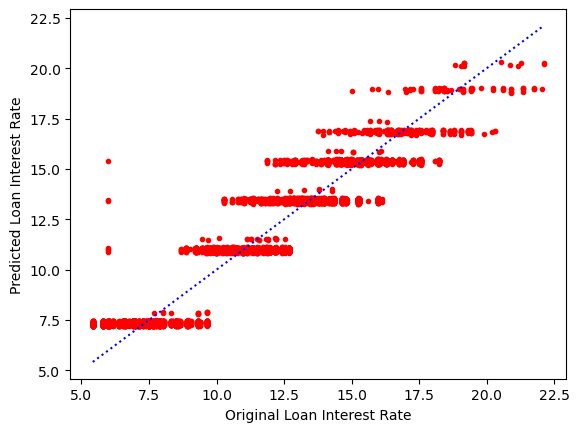

In [225]:
# Predicted values from first stage
treatment_results = {'loan_int_rate':df['loan_int_rate'], 'pred_loan_int_rate':treatment_model.predict()}
df_comparison = pd.DataFrame(treatment_results)

plt.plot(treatment_results['loan_int_rate'], treatment_results['pred_loan_int_rate'],'.',color='r')
x = np.arange(np.min(treatment_results['loan_int_rate']),np.max(treatment_results['loan_int_rate']),0.01)
plt.plot(x,x, color='blue', linestyle = ':')
plt.xlabel('Original Loan Interest Rate')
plt.ylabel('Predicted Loan Interest Rate')

### Assessing Multicollinearity

Based on the following results, since VIFs of ``person_age`` and ``cb_person_cred_hist_length`` are large, it is a sign of multicollinearity. 

In [226]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income',
    'cb_person_cred_hist_length']
# Compute VIF for each confounder
X = df[features]
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                     Variable        VIF
0                  person_age  45.073191
1               person_income  27.625638
2           person_emp_length   2.990407
3                   loan_amnt  28.603024
4         loan_percent_income  27.367122
5  cb_person_cred_hist_length   8.683164


# 5. Logistic Regression

## 5.1. Average Treatment Effect

In this section, we aim to determine the average causal effect of ``loan_int_rate`` on ``loan_status`` using **logistic regression**. Given that older individuals tend to have a longer credit history, multicollinearity is expected. To address this, we remove ``cb_person_cred_hist_length``. Additionally, since ``loan_percent_income`` is derived from ``person_income`` and ``loan_amnt``, we eliminate ``loan_amnt`` and keep only ``person_income`` and ``loan_percent_income`` to minimize redundancy and potential multicollinearity.

### Interpretation of Results

In logistic regression, the coefficient represents the change in the **log-odds** of the outcome (default, loan_status = 1) for a 1-unit increase in the predictor, holding all other variables constant. Here, the coefficient for ``loan_int_rate`` is **1.3547**, which means:

A 1-unit increase in ``loan_int_rate`` (e.g., from 10% to 11%) increases the log-odds of default by 1.3547.

To make this more intuitive, let’s convert the log-odds to an **odds ratio** by exponentiating the coefficient:

$$\text{Odds Ratio} = e^{1.3547}\approx 3.878$$

**Interpretation in Terms of Odds:**

If the odds of default were 1:1 (i.e., 50% probability of default) at a given interest rate, a 1-unit increase in ``loan_int_rate`` would make the odds 3.878:1, meaning the odds of default are now almost 4 times higher.

While the odds ratio is useful, it’s often more intuitive to think in terms of probabilities. However, converting from log-odds (or odds) to probability in logistic regression depends on the baseline probability (i.e., the probability of default at a specific value of ``loan_int_rate`` and with all other variables set to their reference values). So, we do not further dive into details.

In [227]:
removed_features = ['loan_status', 'cb_person_cred_hist_length', 'loan_amnt']
X = df.drop(columns=removed_features)



# Fit logistic regression
ATE_model = sm.Logit(
    df['loan_status'],
    sm.add_constant(X)
).fit()

# Print results
print(ATE_model.summary())




Optimization terminated successfully.
         Current function value: 0.304603
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                16308
Model:                          Logit   Df Residuals:                    16287
Method:                           MLE   Df Model:                           20
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3119
Time:                        18:30:36   Log-Likelihood:                -4967.5
converged:                       True   LL-Null:                       -7219.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.8477      0.302     -2.808      0.005   

### Robust Standard Errors

To account for potential heteroskedasticity or model misspecification, we recompute the logistic regression with robust standard errors (e.g., Huber-White standard errors). Since the results are almost similar, we can conclude that the logistic regression model is robust. The HC1 adjustment makes the standard errors more conservative, which is appropriate given potential heteroskedasticity in loan data, but it doesn’t alter the overall conclusions, as key predictors like loan_int_rate, loan_percent_income, and loan_grade variables remain significant, suggesting that the model is stable and the causal effect of loan_int_rate on loan_status is reliably estimated.

In [133]:
# Fit logistic regression with robust standard errors
Robust_ATE_model = sm.Logit(
    df['loan_status'],
    sm.add_constant(X)
).fit(cov_type='HC1')  # HC1 is a type of robust covariance (Huber-White)

# Print results
print(Robust_ATE_model.summary())

Optimization terminated successfully.
         Current function value: 0.341422
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                28638
Model:                          Logit   Df Residuals:                    28617
Method:                           MLE   Df Model:                           20
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3466
Time:                        16:21:41   Log-Likelihood:                -9777.7
converged:                       True   LL-Null:                       -14965.
Covariance Type:                  HC1   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -3.2659      0.108    -30.126      0.000   

## 5.2. Conditional Averate Treament Effect

Now, we are going to determine the average effect of ``loan_int_rate`` on ``loan_status`` for specific subgroup of individuals. 

The CATE represents the treatment effect of ``loan_int_rate`` on ``loan_status`` conditional on specific values of other variables. In a logistic regression framework, we can estimate CATE by adding interaction terms between ``loan_int_rate`` and variables that are likely to modify its effect on ``loan_status``. By adding interaction terms, we allow the effect of ``loan_int_rate`` to vary across subgroups. Therefore, we add interaction terms into our model. Since the number of observations corresponding ``load_grade`` with levels D, E, F and G are small, we combine them and add its interaction with ``loan_int_rate``. Moreover, we add the interaction term between ``loan_int_rate`` and ``loan_intent``.

The logistic regression results show that ``loan_int_rate`` has a significant positive coefficient (6.9850, p < 0.000), meaning higher interest rates are associated with a higher log-odds of loan_status = 1 (likely default). However, this effect might differ based on factors like loan grade, income, or loan purpose.

Based on the results, adding interaction between some confounders and the treatment variable improves slightly the performance of the model.

In [183]:
removed_features = ['loan_status', 'cb_person_cred_hist_length', 'loan_amnt']

X = df.drop(columns=removed_features)


lgrade_D_G = df['loan_grade_D']+df['loan_grade_E']+df['loan_grade_F']+df['loan_grade_G']
X['int_loan_B']=df['loan_int_rate']*df['loan_grade_B']
X['int_loan_C']=df['loan_int_rate']*df['loan_grade_C']
X['int_loan_D-G']=df['loan_int_rate']*lgrade_D_G

X['int_EDUCATION']=df['loan_int_rate']*df['loan_intent_EDUCATION']
X['int_HOMEIMPROVEMENT']=df['loan_int_rate']*df['loan_intent_HOMEIMPROVEMENT']
X['int_MEDICAL']=df['loan_int_rate']*df['loan_intent_MEDICAL']
X['int_PERSONAL']=df['loan_int_rate']*df['loan_intent_PERSONAL']
X['int_VENTURE']=df['loan_int_rate']*df['loan_intent_VENTURE']


In [184]:
# Fit logistic regression
CATE = sm.Logit(
    df['loan_status'],
    sm.add_constant(X)
).fit()

# Print results
print(CATE.summary())

Optimization terminated successfully.
         Current function value: 0.298222
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                16308
Model:                          Logit   Df Residuals:                    16279
Method:                           MLE   Df Model:                           28
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3263
Time:                        18:19:49   Log-Likelihood:                -4863.4
converged:                       True   LL-Null:                       -7219.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.4709      0.248     -9.968      0.000   

## Check Confounding Balance

For causal inference, we need to ensure that the confounders (e.g., ``person_income``, ``loan_grade``) adequately control for confounding. One way to check this is to examine the balance of confounders across levels of the treatment (``loan_int_rate``).

Since ``loan_int_rate`` is continuous, we can discretize it into bins (e.g., quartiles) and check the balance of confounders across these bins.

Based on the results, since the p-values for ``person_emp_length`` and ``loan_percent_income`` are small, it suggests that your model might not fully control for confounding, and the causal estimate of ``loan_int_rate`` could be biased.

In [156]:
# Discretize loan_int_rate into quartiles
import copy
df_new = copy.deepcopy(df)
df_new['loan_int_rate_bins'] = pd.qcut(df['loan_int_rate'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Check the mean of confounders across bins
confounders = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
balance_table = df_new.groupby('loan_int_rate_bins')[confounders].mean()
print("Mean of confounders across loan_int_rate bins:")
print(balance_table)

# Perform ANOVA to test for significant differences
from scipy.stats import f_oneway

for confounder in confounders:
    groups = [df_new[df['loan_int_rate_bins'] == bin_][confounder] for bin_ in ['Q1', 'Q2', 'Q3', 'Q4']]
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA for {confounder}: F-stat = {f_stat:.4f}, p-value = {p_value:.4f}")

Mean of confounders across loan_int_rate bins:
                    person_age  person_income  person_emp_length  \
loan_int_rate_bins                                                 
Q1                    0.061784       0.010561           0.043077   
Q2                    0.062394       0.010325           0.038090   
Q3                    0.061788       0.010511           0.036633   
Q4                    0.063345       0.010388           0.037758   

                    loan_percent_income  
loan_int_rate_bins                       
Q1                             0.182156  
Q2                             0.204418  
Q3                             0.211498  
Q4                             0.219760  
ANOVA for person_age: F-stat = 1.4915, p-value = 0.2146
ANOVA for person_income: F-stat = 0.7860, p-value = 0.5015
ANOVA for person_emp_length: F-stat = 52.9320, p-value = 0.0000
ANOVA for loan_percent_income: F-stat = 116.8039, p-value = 0.0000
